In [30]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

In [31]:
series = np.sin((0.1*np.arange(800))**2)

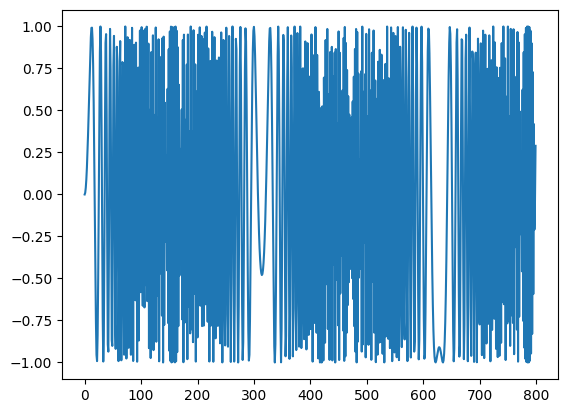

In [32]:
plt.plot(series)
plt.show()

In [33]:
#Build the data
N = len(series)
T = 10
X = []
Y = []

for t in range(len(series)-T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1,T,1)

Y = np.array(Y).reshape(-1,1)

X.shape, Y.shape

((790, 10, 1), (790, 1))

In [34]:
#SPlit the data
N = len(X)
X_train =  torch.from_numpy(X[:N//2].astype("float32"))
X_test = torch.from_numpy(X[N//2:].astype("float32"))
Y_train = torch.from_numpy(Y[:N//2].astype("float32"))
Y_test = torch.from_numpy(Y[N//2:].astype("float32"))

X_train.shape,X_test.shape,Y_train.shape , Y_test.shape

(torch.Size([395, 10, 1]),
 torch.Size([395, 10, 1]),
 torch.Size([395, 1]),
 torch.Size([395, 1]))

In [35]:
device = torch.device("cuda:0")
print(device)

cuda:0


In [36]:
X_train, X_test, Y_train, Y_test = X_train.to(device), X_test.to(device), Y_train.to(device), Y_test.to(device)

In [37]:
#RNN model

class RNN(nn.Module):
  def __init__(self, hidden, inputs, outputs):
    super(RNN,self).__init__()

    self.D  = inputs
    self.M = hidden
    self.K = outputs

    self.rnn = nn.RNN(input_size = self.D, hidden_size = self.M, nonlinearity = "tanh", batch_first = True)

    self.fc = nn.Linear(self.M,self.K)

  def forward(self,x):

    h_0 = torch.zeros(1, x.shape[0],self.M).to(device)

    out, _ = self.rnn(x,h_0)

    out = self.fc(out[:,-1,:])

    return out



In [38]:
model = RNN(5,1,1)
model.to(device)

RNN(
  (rnn): RNN(1, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [39]:
#optimizer

criterion = nn.MSELoss()
optimizer  = torch.optim.Adam(model.parameters(),lr=0.01)

In [40]:
#training

epochs = 500

train_loss = np.zeros(epochs)

test_loss  = np.zeros(epochs)

for i in range(epochs):

  optimizer.zero_grad()

  outputs  =  model(X_train)

  loss  = criterion(outputs, Y_train)

  loss.backward()

  optimizer.step()

  train_loss[i] = loss.item()

  o = model(X_test)

  loss_test = criterion(o,Y_test)

  test_loss[i] = loss_test.item()

  print(f"epochs -- {i+1}/{epochs} , training loss -- {loss.item()} , test loss -- {loss_test.item()}")


epochs -- 1/500 , training loss -- 0.6589529514312744 , test loss -- 0.6067969799041748
epochs -- 2/500 , training loss -- 0.6045054197311401 , test loss -- 0.5735905766487122
epochs -- 3/500 , training loss -- 0.5621834993362427 , test loss -- 0.551820695400238
epochs -- 4/500 , training loss -- 0.5316420793533325 , test loss -- 0.5399228930473328
epochs -- 5/500 , training loss -- 0.5117857456207275 , test loss -- 0.5360294580459595
epochs -- 6/500 , training loss -- 0.5009925961494446 , test loss -- 0.538261890411377
epochs -- 7/500 , training loss -- 0.4973470866680145 , test loss -- 0.5445531010627747
epochs -- 8/500 , training loss -- 0.49873796105384827 , test loss -- 0.5526830554008484
epochs -- 9/500 , training loss -- 0.5029658675193787 , test loss -- 0.560581386089325
epochs -- 10/500 , training loss -- 0.5079885125160217 , test loss -- 0.5666826367378235
epochs -- 11/500 , training loss -- 0.5122265219688416 , test loss -- 0.5701366066932678
epochs -- 12/500 , training loss

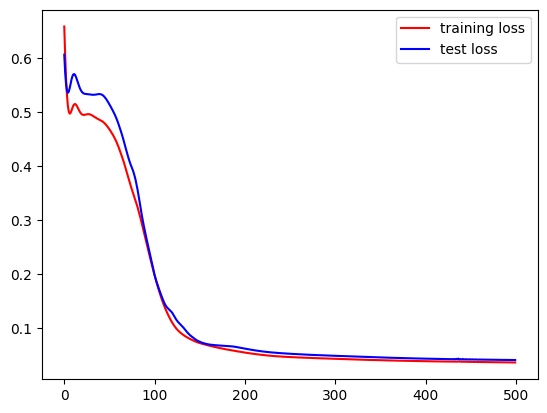

In [41]:
plt.plot(train_loss, label = "training loss", c = "r")
plt.plot(test_loss, label = "test loss", c = "b")
plt.legend()
plt.show()

In [43]:
#one step forecasting

test_predictions  = model(X_test).detach().cpu().numpy()



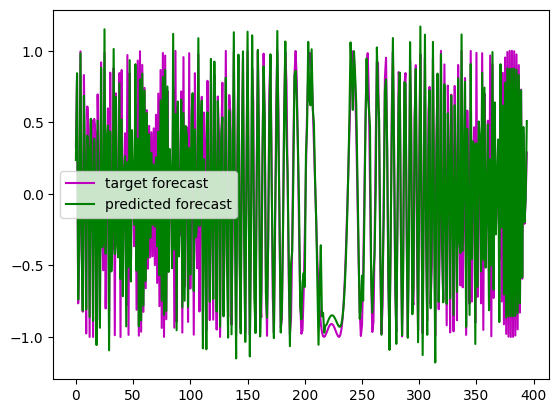

In [45]:
plt.plot(Y_test.cpu().numpy(), label = "target forecast", c = "m")
plt.plot(test_predictions, label = "predicted forecast", c = "g")
plt.legend()
plt.show()

In [49]:
#multistep forecasting

test_predictions = []

last_x = X_test[0]

while len(test_predictions) < len(X_test):

  out = model(last_x.reshape(1,T,1))

  test_predictions.append(out.item())

  x = torch.cat((last_x[1:],out))

  last_x = x

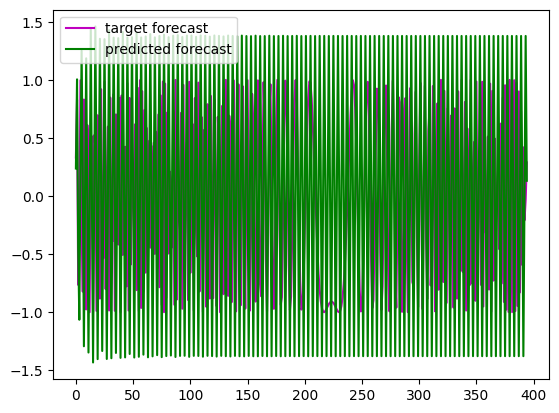

In [51]:
plt.plot(Y_test.cpu().numpy(), label = "target forecast", c = "m")
plt.plot(test_predictions, label = "predicted forecast", c = "g")
plt.legend()
plt.show()